In [ ]:
from __future__ import annotations
import math
import random
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Dict, Optional

import numpy as np


# ------------------------------------------------------------
# Helper: log-normal radius generator
# ------------------------------------------------------------
def make_lognormal_sampler(median: float,
                           gsd: float,
                           r_min: float,
                           r_max: float) -> Callable[[], float]:
    """
    Return a function that draws radii R ~ logN(μ,σ) truncated to [r_min, r_max].

    Parameters
    ----------
    median : float
        Median radius (exp(μ)).
    gsd : float
        Geometric standard deviation (>1).  σ = ln(gsd).
    r_min, r_max : float
        Hard cut-offs to avoid extreme outliers.

    Returns
    -------
    sampler : callable
        When called, returns a single random radius.
    """
    mu = math.log(median)
    sigma = math.log(gsd)

    def _sample() -> float:
        while True:
            r = random.lognormvariate(mu, sigma)
            if r_min <= r <= r_max:
                return r

    return _sample


# ------------------------------------------------------------
# Main 2-D packing engine
# ------------------------------------------------------------
@dataclass
class DropletPacking2D:
    L: float = 1.0                      # Domain side length
    N_fail_max: int = 50_000            # Stop after this many consecutive failures
    seed: Optional[int] = 42            # RNG seed for reproducibility
    cell_size: Optional[float] = None   # Grid cell dimension (set after first draw)
    radii_sampler: Callable[[], float] = field(
        default_factory=lambda: make_lognormal_sampler(
            median=0.035, gsd=1.3, r_min=0.005, r_max=0.08)
    )

    # internal containers
    particles: List[Tuple[float, float, float]] = field(default_factory=list)
    _grid: Dict[Tuple[int, int], List[int]] = field(init=False, default_factory=dict)

    def __post_init__(self):
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)  # keep numpy in sync
        # we do *not* know max radius until first sample; postpone cell_size

    # -------------- grid helpers ------------------------------------------
    def _cell_index(self, x: float, y: float) -> Tuple[int, int]:
        c = self.cell_size
        return int(x // c), int(y // c)

    def _neighbour_cells(self, ci: int, cj: int) -> List[Tuple[int, int]]:
        # nine surrounding cells (including self)
        return [(ci + dx, cj + dy) for dx in (-1, 0, 1) for dy in (-1, 0, 1)]

    def _add_to_grid(self, idx: int, x: float, y: float):
        ci, cj = self._cell_index(x, y)
        self._grid.setdefault((ci, cj), []).append(idx)

    def _overlaps(self, x: float, y: float, r: float) -> bool:
        ci, cj = self._cell_index(x, y)
        for nci, ncj in self._neighbour_cells(ci, cj):
            for idx in self._grid.get((nci, ncj), []):
                x2, y2, r2 = self.particles[idx]
                if (x - x2) ** 2 + (y - y2) ** 2 < (r + r2) ** 2:
                    return True
        return False

    # -------------- RSA stage ---------------------------------------------
    def run_rsa(self):
        """
        Populate the domain until jammed (RSA).  Fills self.particles.
        """
        failures = 0
        first_r = self.radii_sampler()
        if self.cell_size is None:
            # choose a grid with cells just larger than the largest allowed radius
            self.cell_size = 2.1 * first_r
        # place the first droplet
        while True:
            x = random.uniform(first_r, self.L - first_r)
            y = random.uniform(first_r, self.L - first_r)
            self.particles.append((x, y, first_r))
            self._add_to_grid(0, x, y)
            break  # first droplet always succeeds

        while failures < self.N_fail_max:
            r = self.radii_sampler()
            # early-reject if r > cell_size/2; can’t fit in current grid holes
            if r > 0.5 * self.cell_size:
                failures += 1
                continue
            x = random.uniform(r, self.L - r)
            y = random.uniform(r, self.L - r)
            if self._overlaps(x, y, r):
                failures += 1
                continue
            # success
            idx = len(self.particles)
            self.particles.append((x, y, r))
            self._add_to_grid(idx, x, y)
            failures = 0  # reset
        # done: jammed
        return self.packing_fraction()

    # -------------- shaking stage -----------------------------------------
    def shake(self,
              n_sweeps: int = 3,
              step_frac: float = 0.15):
        """
        Local Monte-Carlo shaking.  After shaking, attempt another RSA fill.

        Parameters
        ----------
        n_sweeps : int
            How many full passes over all particles to attempt moves.
        step_frac : float
            Max displacement as fraction of particle radius.
        """
        for _ in range(n_sweeps):
            order = list(range(len(self.particles)))
            random.shuffle(order)
            for idx in order:
                x, y, r = self.particles[idx]
                dx = (random.random() * 2 - 1) * step_frac * r
                dy = (random.random() * 2 - 1) * step_frac * r
                xn, yn = x + dx, y + dy
                # keep inside domain
                if xn - r < 0 or xn + r > self.L or yn - r < 0 or yn + r > self.L:
                    continue
                # temp remove from grid
                ci, cj = self._cell_index(x, y)
                self._grid[(ci, cj)].remove(idx)
                if self._overlaps(xn, yn, r):
                    # revert
                    self._grid[(ci, cj)].append(idx)
                    continue
                # accept move
                self.particles[idx] = (xn, yn, r)
                self._add_to_grid(idx, xn, yn)

        # after shaking, try to add more droplets (secondary RSA)
        self.run_rsa()

    # -------------- metrics ------------------------------------------------
    def packing_fraction(self) -> float:
        area = sum(math.pi * r ** 2 for _, _, r in self.particles)
        return area / (self.L * self.L)

    # -------------- utility -----------------------------------------------
    def summary(self, label="") -> str:
        phi = self.packing_fraction()
        return (f"{label} N={len(self.particles)}  "
                f"phi={phi:.4f}  ")


# ------------------------------------------------------------
# Simple 3-D stub (extend later)
# ------------------------------------------------------------
class DropletPacking3D:
    """Skeleton showing how to structure the 3-D version."""
    def __init__(self, L=1.0, seed=42):
        self.L = L
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        # TODO: octree cell-list, sphere overlap, RSA loop identical in spirit

    # implement run_rsa_3d, shake_3d, etc.
    ...


# ------------------------------------------------------------
# Example usage
# ------------------------------------------------------------
if __name__ == "__main__":
    # 1. define a realistic log-normal size law (~mayo droplets)
    R_MEDIAN = 0.02       # 20 μm if L=1 corresponds to 1 mm domain
    GSD = 1.8             # moderately broad
    R_MIN, R_MAX = 0.005, 0.06
    sampler = make_lognormal_sampler(R_MEDIAN, GSD, R_MIN, R_MAX)

    sim = DropletPacking2D(L=1.0,
                           N_fail_max=100_000,
                           radii_sampler=sampler,
                           seed=2025)

    phi_rsa = sim.run_rsa()
    print(sim.summary("RSA jammed"))

    sim.shake(n_sweeps=4, step_frac=0.10)
    print(sim.summary("After shaking"))


RSA jammed N=2174  phi=0.6399  median r=0.0072
After shaking N=2257  phi=0.6555  median r=0.0071


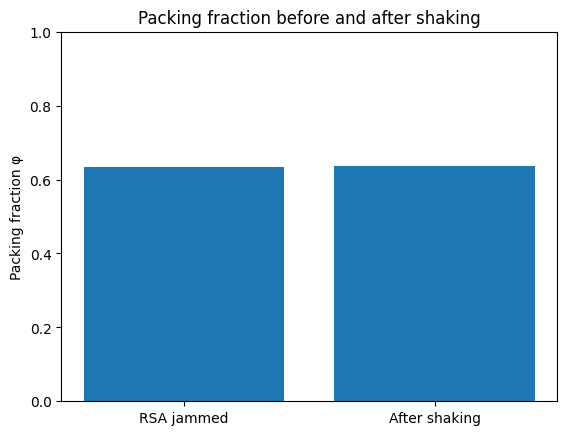

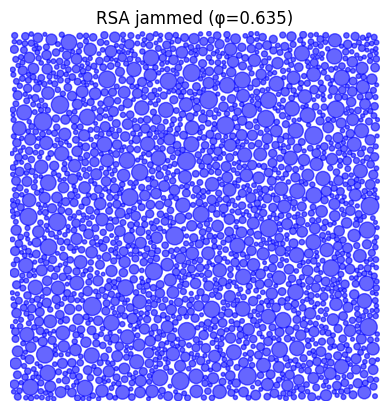

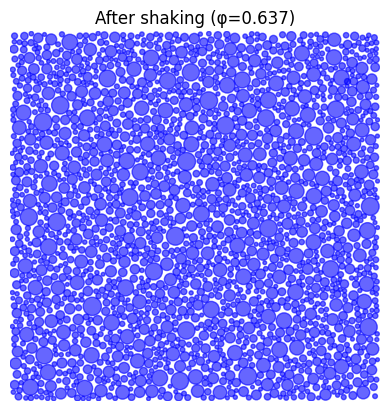

RSA jammed N=2127  phi=0.6352  median r=0.0073
After shaking N=2148  phi=0.6373  median r=0.0072


In [10]:
import math, random
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# Helper: truncated log-normal sampler
# -------------------------------------------------------------------------
def make_lognormal_sampler(median: float,
                           gsd: float,
                           r_min: float,
                           r_max: float) -> Callable[[], float]:
    mu = math.log(median)
    sigma = math.log(gsd)

    def _sample() -> float:
        while True:
            r = random.lognormvariate(mu, sigma)
            if r_min <= r <= r_max:
                return r
    return _sample


# -------------------------------------------------------------------------
# 2-D polydisperse RSA with grid acceleration + optional shaking
# -------------------------------------------------------------------------
@dataclass
class DropletPacking2D:
    L: float = 1.0
    N_fail_max: int = 50_000
    seed: Optional[int] = 2025
    radii_sampler: Callable[[], float] = field(
        default_factory=lambda: make_lognormal_sampler(0.02, 1.8, 0.005, 0.06)
    )
    cell_size: Optional[float] = None

    particles: List[Tuple[float, float, float]] = field(default_factory=list)
    _grid: Dict[Tuple[int, int], List[int]] = field(init=False, default_factory=dict)

    def __post_init__(self):
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

    # --- grid helpers ---
    def _cell_index(self, x, y):
        c = self.cell_size
        return int(x // c), int(y // c)

    def _neigh_cells(self, ci, cj):
        return [(ci+dx, cj+dy) for dx in (-1,0,1) for dy in (-1,0,1)]

    def _add(self, idx, x, y):
        ci,cj = self._cell_index(x,y)
        self._grid.setdefault((ci,cj), []).append(idx)

    def _overlap(self, x, y, r):
        ci,cj = self._cell_index(x,y)
        for nci,ncj in self._neigh_cells(ci,cj):
            for idx in self._grid.get((nci,ncj), []):
                x2,y2,r2 = self.particles[idx]
                if (x-x2)**2 + (y-y2)**2 < (r+r2)**2:
                    return True
        return False

    # --- RSA ---
    def run_rsa(self):
        failures = 0
        r0 = self.radii_sampler()
        if self.cell_size is None:
            self.cell_size = 2.1 * r0
        placed = False
        while not placed:
            x = random.uniform(r0, self.L-r0)
            y = random.uniform(r0, self.L-r0)
            self.particles.append((x,y,r0))
            self._add(len(self.particles) - 1, x, y)
            placed = True
        while failures < self.N_fail_max:
            r = self.radii_sampler()
            if r > 0.5*self.cell_size:
                failures += 1
                continue
            x = random.uniform(r, self.L-r)
            y = random.uniform(r, self.L-r)
            if self._overlap(x,y,r):
                failures += 1
                continue
            idx = len(self.particles)
            self.particles.append((x,y,r))
            self._add(idx,x,y)
            failures = 0
        return self.packing_fraction()

    # --- shaking ---
    def shake(self, n_sweeps=4, step_frac=0.10):
        for _ in range(n_sweeps):
            order = list(range(len(self.particles)))
            random.shuffle(order)
            for idx in order:
                x,y,r = self.particles[idx]
                dx = (random.random()*2-1)*step_frac*r
                dy = (random.random()*2-1)*step_frac*r
                xn,yn = x+dx, y+dy
                if xn-r<0 or xn+r>self.L or yn-r<0 or yn+r>self.L:
                    continue
                ci,cj = self._cell_index(x,y)
                self._grid[(ci,cj)].remove(idx)
                if self._overlap(xn,yn,r):
                    self._grid[(ci,cj)].append(idx)
                    continue
                self.particles[idx]=(xn,yn,r)
                self._add(idx,xn,yn)
        self.run_rsa()

    # --- metrics ---
    def packing_fraction(self):
        return sum(math.pi*r**2 for _,_,r in self.particles)/(self.L*self.L)

    def summary(self, label="") -> str:
        phi = self.packing_fraction()
        return (f"{label} N={len(self.particles)}  "
                f"phi={phi:.4f}  "
                f"median r={np.median([p[2] for p in self.particles]):.4f}")


# -------------------------------------------------------------------------
# Run simulation
# -------------------------------------------------------------------------
sim = DropletPacking2D()
phi_before = sim.run_rsa()
particles_before = sim.particles.copy()


sim.shake()
phi_after = sim.packing_fraction()
particles_after = sim.particles.copy()






# -------------------------------------------------------------------------
# Bar chart of packing fractions
# -------------------------------------------------------------------------
fig1 = plt.figure()
plt.bar(['RSA jammed', 'After shaking'], [phi_before, phi_after])
plt.ylabel('Packing fraction φ')
plt.title('Packing fraction before and after shaking')
plt.ylim(0,1)
plt.show()

# -------------------------------------------------------------------------
# Configuration plots (two separate figures, as required)
# -------------------------------------------------------------------------
def plot_config(particles, L, title):
    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    for x,y,r in particles:
        circle = plt.Circle((x,y), r, color='b', alpha=0.6)
        ax.add_patch(circle)
    ax.set_xlim(0,L); ax.set_ylim(0,L)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_config(particles_before, sim.L, f'RSA jammed (φ={phi_before:.3f})')
plot_config(particles_after, sim.L, f'After shaking (φ={phi_after:.3f})')



# phi_rsa = sim.run_rsa()
# print(sim.summary("RSA jammed"))

# sim.shake(n_sweeps=4, step_frac=0.10)
# print(sim.summary("After shaking"))
sim = DropletPacking2D()
sim.run_rsa()
print(sim.summary("RSA jammed"))   # 输出 jammed 状态

sim.shake()
print(sim.summary("After shaking"))  # 输出摇动后的状态


